# Variability Statistics 

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

## varMetricsFull : stats on full unbinned LC , 1000 bootstraps

In [2]:

DirStat =  '/astro/store/scratch/tmp/suberlak/s13_stripe82/forced_phot_lt_23/NCSA/Var/'
filters = 'g'
patch = '00_21'
File = 'Var'+filter+patch+'.csv'
varMetricsFull = pd.read_csv(DirStat+File)

DirEBV = '/astro/store/scratch/tmp/suberlak/S13Agg/'
ebv = pd.read_csv(DirEBV+'medianPhotometry.csv', usecols=['objectId','ebv'])


In [74]:
varPatch = {}

In [75]:
patch = '00_21'
for filter in 'ugriz':
    File = 'Var'+filter+patch+'.csv'
    varPatch[filter] = pd.read_csv(DirStat+File)

In [76]:
# That's expected since we have exactly the same objects in each patch file ...
# That does not depend on filter !  
for filter in 'ugriz':
    print(np.sum(np.in1d(varPatch[filter]['objectId'].values,ebv['objectId'].values)))

487054
487054
487054
487054
487054


In [152]:
for filter in 'ugriz':
    length = len(varPatch[filter][filter+'psfMean'].values)
    infinite = np.sum(~np.isfinite(varPatch[filter][filter+'psfMean'].values))
    nans = np.sum(np.isnan(varPatch[filter][filter+'psfMean'].values))
    print('%s : %d  NaN , %d / %d not finite \n'% (filter, nans, infinite , length))

u : 0  NaN , 0 / 490598 not finite 

g : 0  NaN , 0 / 490369 not finite 

r : 0  NaN , 0 / 490175 not finite 

i : 0  NaN , 0 / 490112 not finite 

z : 0  NaN , 0 / 490566 not finite 



In [157]:
# Check if each patch file has exactly the same number of objects... 

for filter in 'ugriz':
    print('Number of unique objectId in %s is %d'%(filter, len(np.unique(varPatch[filter]['objectId'].values))))

# They don't ! So to save time that would need to waste taking care of all objects that 
# don't have observations in all filters, just ignore them, by making an 'inner' merge 

Number of unique objectId in u is 490598
Number of unique objectId in g is 490369
Number of unique objectId in r is 490175
Number of unique objectId in i is 490112
Number of unique objectId in z is 490566


(array([  8.70000000e+01,   6.16000000e+02,   1.31300000e+03,
          2.26300000e+03,   3.65700000e+03,   6.44600000e+03,
          1.71160000e+04,   5.84600000e+04,   2.75764000e+05,
          1.24647000e+05]),
 array([ 10.67860337,  12.19525518,  13.71190699,  15.2285588 ,
         16.74521061,  18.26186242,  19.77851423,  21.29516604,
         22.81181785,  24.32846966,  25.84512147]),
 <a list of 10 Patch objects>)

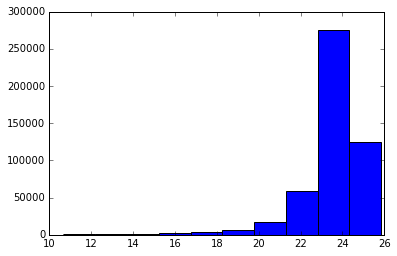

In [153]:
filter='g'
g = varPatch[filter][filter+'psfMean'].values
plt.hist(g)

In [80]:
varPatch['r'].columns

Index([u'objectId', u'N', u'avgMJD', u'chi2DOF', u'chi2R', u'flagLtTenPts',
       u'muFull', u'psfFluxMean', u'psfFluxMeanErr', u'psfFluxMedian',
       u'psfFluxMedianErr', u'psfFluxSigG', u'psfFluxSkew', u'psfFluxStDev',
       u'rangeMJD', u'sigmaFull', u'psfMean', u'psfMedian', u'psfMeanErr',
       u'psfMedianErr'],
      dtype='object')

In [70]:
#varPatch['g'].columns = [col[2:] for col in varPatch['g']]

In [81]:
# add prefix for each filter, apart from the objectId column  
for filter in 'ugriz':
    varPatch[filter].columns = [filter+col  if col != 'objectId' else col for col in varPatch[filter]]

In [82]:
varPatch['g'].columns

Index([u'objectId', u'gN', u'gavgMJD', u'gchi2DOF', u'gchi2R',
       u'gflagLtTenPts', u'gmuFull', u'gpsfFluxMean', u'gpsfFluxMeanErr',
       u'gpsfFluxMedian', u'gpsfFluxMedianErr', u'gpsfFluxSigG',
       u'gpsfFluxSkew', u'gpsfFluxStDev', u'grangeMJD', u'gsigmaFull',
       u'gpsfMean', u'gpsfMedian', u'gpsfMeanErr', u'gpsfMedianErr'],
      dtype='object')

In [158]:
howmerge='inner' # to avoid those objects which were in one filter but not in the other...
varPatchug = pd.merge(varPatch['u'], varPatch['g'], how=howmerge, on='objectId', copy=True, indicator=False)
varPatchugr = pd.merge(varPatchug, varPatch['r'], how=howmerge, on='objectId', copy=True, indicator=False)
varPatchiz = pd.merge(varPatch['i'], varPatch['z'], how=howmerge, on='objectId', copy=True, indicator=False)
varPatchugriz = pd.merge(varPatchugr, varPatchiz , how=howmerge, on='objectId', copy=True, indicator=False)

In [159]:
len(varPatchugriz.columns)

96

In [160]:
len(varPatchugriz['objectId'].values)

489986

In [161]:
len(varPatch['u']['objectId'].values)
# All good : merged object has exactly the same number of objects as the idividual filters we started with... 
# Well, it has the same number of objectIds as u if we start with u and then 'left' merge everything onto it. 
# But because there are few objectIds that are not present in all filters, for now just ignore them,
# by doing an inner merge ... 

490598

In [167]:
withEBV = np.sum(np.in1d(varPatchugriz['objectId'].values, ebv['objectId'].values))
allOBJ = len(varPatchugriz['objectId'].values)
print('Of all %d objects, %d have E(B-V) values from medianPhotometry.csv'%(allOBJ, withEBV))

Of all 489986 objects, 487054 have E(B-V) values from medianPhotometry.csv


In [168]:
# Now this can be a left merge, since I know that all objects 
varPatchAll =pd.merge(varPatchugriz, ebv, how='inner', on='objectId', copy=True, indicator=False)

In [171]:
# Since I make an inner merge, I keep only those objects that have the E(B-V) measurements
len(varPatchAll['objectId'].values)

487054

In [86]:
from pandas import compat
compat.PY3 = True


In [172]:
# So at this point I only have objects that have 
# 1) measurements in all ugriz fulters 
# 2) E(B-V) value 
varPatchAll.columns

Index(['objectId', 'uN', 'uavgMJD', 'uchi2DOF', 'uchi2R', 'uflagLtTenPts',
       'umuFull', 'upsfFluxMean', 'upsfFluxMeanErr', 'upsfFluxMedian',
       'upsfFluxMedianErr', 'upsfFluxSigG', 'upsfFluxSkew', 'upsfFluxStDev',
       'urangeMJD', 'usigmaFull', 'upsfMean', 'upsfMedian', 'upsfMeanErr',
       'upsfMedianErr', 'gN', 'gavgMJD', 'gchi2DOF', 'gchi2R', 'gflagLtTenPts',
       'gmuFull', 'gpsfFluxMean', 'gpsfFluxMeanErr', 'gpsfFluxMedian',
       'gpsfFluxMedianErr', 'gpsfFluxSigG', 'gpsfFluxSkew', 'gpsfFluxStDev',
       'grangeMJD', 'gsigmaFull', 'gpsfMean', 'gpsfMedian', 'gpsfMeanErr',
       'gpsfMedianErr', 'rN', 'ravgMJD', 'rchi2DOF', 'rchi2R', 'rflagLtTenPts',
       'rmuFull', 'rpsfFluxMean', 'rpsfFluxMeanErr', 'rpsfFluxMedian',
       'rpsfFluxMedianErr', 'rpsfFluxSigG', 'rpsfFluxSkew', 'rpsfFluxStDev',
       'rrangeMJD', 'rsigmaFull', 'rpsfMean', 'rpsfMedian', 'rpsfMeanErr',
       'rpsfMedianErr', 'iN', 'iavgMJD', 'ichi2DOF', 'ichi2R', 'iflagLtTenPts',
       'imuFull'

## Correct for extinction  

In [173]:
A = [5.155, 3.793, 2.751, 2.086, 1.479]
filters = 'ugriz'

for i in range(len(A)):
    label = filters[i] + 'psfMean'
    varPatchAll[label+'_corr'] = varPatchAll[label] +  varPatchAll['ebv'] * A[i]

## Per filter plots...

Saved as data_products/u00_21_mag_chi2_ratio.png 


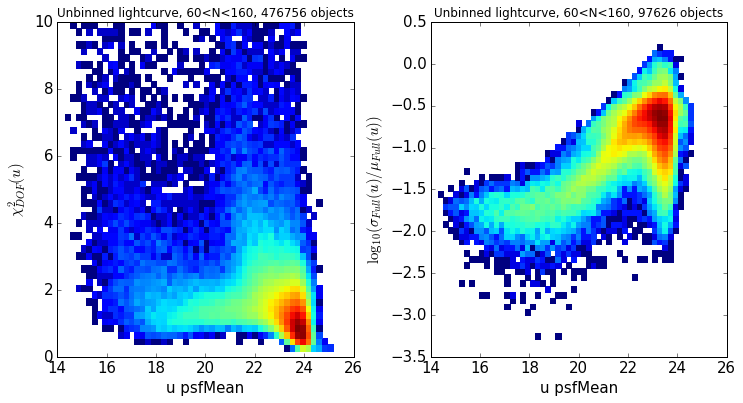

Saved as data_products/g00_21_mag_chi2_ratio.png 


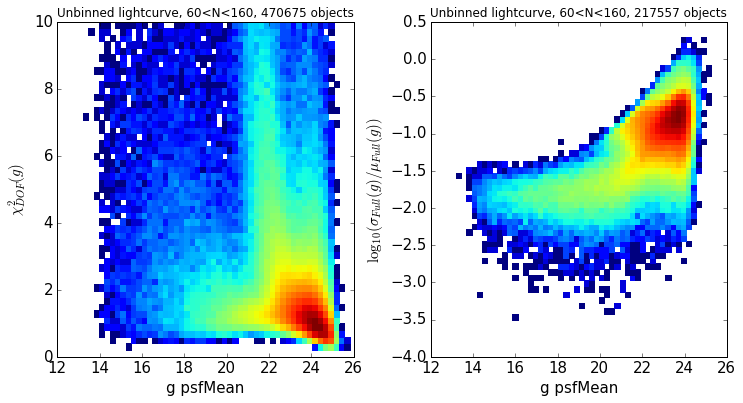

Saved as data_products/r00_21_mag_chi2_ratio.png 


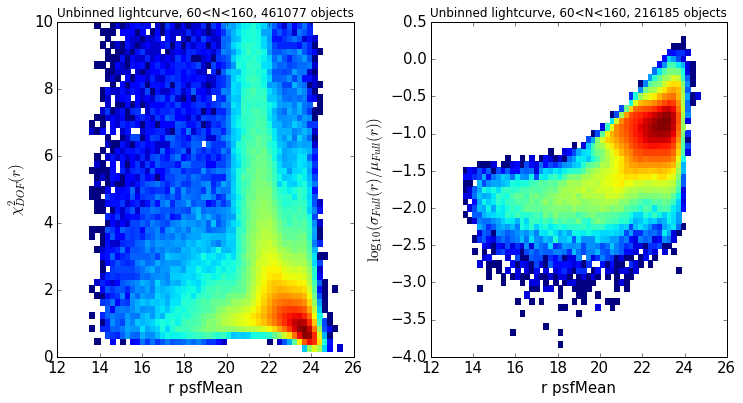

Saved as data_products/i00_21_mag_chi2_ratio.png 


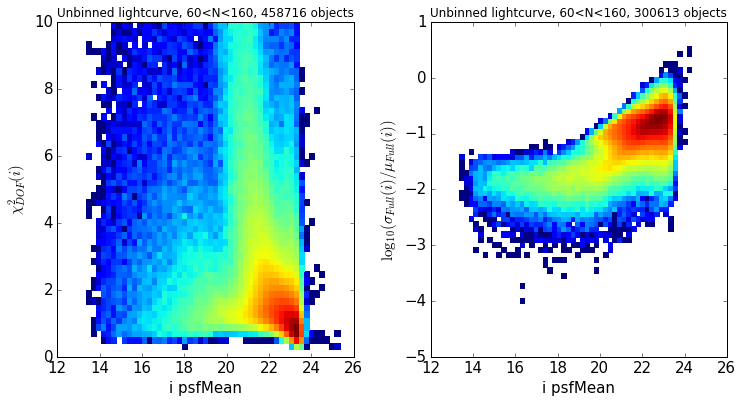

Saved as data_products/z00_21_mag_chi2_ratio.png 


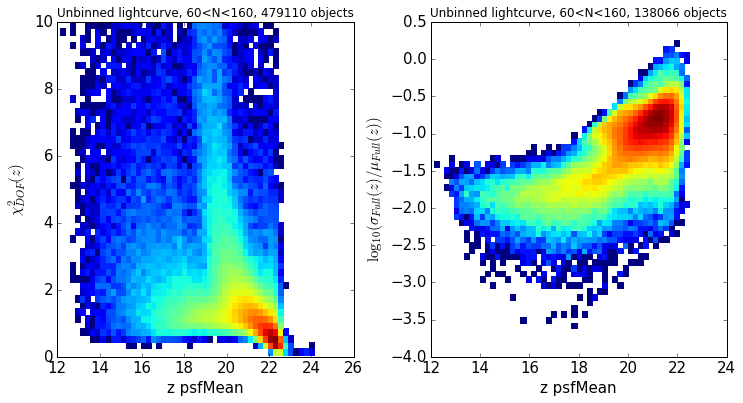

In [293]:
# We make one such plot per filter ...
for filter in 'ugriz':
    #filter  = 'u'
    fig, ax = plt.subplots(1,2, figsize=(12,6))

    chi2max = 10
    mask_chi2 = varPatchAll[filter+'chi2DOF'].values < chi2max
    mask_n_points = (varPatchAll[filter+'N'].values > 60) & (varPatchAll[filter+'N'].values < 160)
    mask_total = mask_n_points & mask_chi2

    nObj = len(varPatchAll[filter+'N'][mask_total].values)
    chi2 = varPatchAll[filter+'chi2DOF'][mask_total].values
    mag = varPatchAll[filter+'psfMean'][mask_total].values
    H, xedges, yedges = np.histogram2d(mag,chi2, bins=50)
    H = np.rot90(H)
    H = np.flipud(H)
    # Mask zeros
    Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zeropltssssss
    # Plot 2D histogram using pcolor
    ax[0].pcolormesh(xedges,yedges,np.log10(Hmasked), cmap='jet')
    #ax.plot(np.linspace(0,4), np.linspace(0,4), ls='--', lw=4)
    ax[0].set_xlabel(filter+' psfMean', fontsize=15)
    ax[0].set_ylabel(r'$\chi^{2}_{DOF}('+filter+')$', fontsize=15)
    ax[0].set_title('Unbinned lightcurve, %d<N<%d, %d objects'%(60,160,nObj))
    ax[0].tick_params(axis='both', which='major', labelsize=15) 


    mask_sigma = (varPatchAll[filter+'sigmaFull'].values > 0) & (varPatchAll[filter+'sigmaFull'].values <50)
    mask_total = mask_n_points & mask_chi2 & mask_sigma

    nObj = len(varPatchAll[filter+'N'][mask_total].values)
    r = varPatchAll[filter+'sigmaFull'][mask_total].values / varPatchAll[filter+'muFull'][mask_total].values
    mag = varPatchAll[filter+'psfMean'][mask_total].values
    H, xedges, yedges = np.histogram2d(mag,np.log10(r), bins=50)
    H = np.rot90(H)
    H = np.flipud(H)
    # Mask zeros
    Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zeropltssssss
    # Plot 2D histogram using pcolor
    ax[1].pcolormesh(xedges,yedges,np.log10(Hmasked), cmap='jet')
    #ax.plot(np.linspace(0,4), np.linspace(0,4), ls='--', lw=4)
    ax[1].set_xlabel(filter+' psfMean', fontsize=15)
    ax[1].set_ylabel(r'$\log_{10}(\sigma_{Full}('+filter+')/ \mu_{Full}('+filter+'))}$', fontsize=15)
    ax[1].set_title('Unbinned lightcurve, %d<N<%d, %d objects'%(60,160,nObj))
    ax[1].tick_params(axis='both', which='major', labelsize=15) 
    fig.subplots_adjust(wspace=0.26)
    name = 'data_products/'+filter+patch+'_mag_chi2_ratio.png'
    print('Saved as %s '%name)
    plt.savefig(name)
    plt.show()

## Sesar+2007 Fig.3: using ugr, $\sigma$ and $\chi$ 

In [215]:
# Define variable sources : my sigma has weird units that I don't claim to entirely understand, 
# but they are neither flux nor magniture

mask_chi2_g = varPatchAll['gchi2DOF'].values > 3
print np.sum(mask_chi2_g)
mask_chi2_r = varPatchAll['rchi2DOF'].values > 3
print np.sum(mask_chi2_r)
mask_sigmaF_g = varPatchAll['gsigmaFull'].values > 0.005
print np.sum(mask_sigmaF_g)
mask_sigmaF_r = varPatchAll['rsigmaFull'].values > 0.005
print np.sum(mask_sigmaF_r)
mask_combined = mask_chi2_g & mask_chi2_r & mask_sigmaF_g & mask_sigmaF_r
print np.sum(mask_combined)

50152
68907
54541
105854
34788


In [243]:
np.sum(mask_combined & mask_total)

9417

In [597]:
np.arange(19,23)

array([19, 20, 21, 22])

Saved as data_products/Sesar_2007_Fig3_patch00_21_g_lt_19.png 
Saved as data_products/Sesar_2007_Fig3_patch00_21_g_lt_20.png 
Saved as data_products/Sesar_2007_Fig3_patch00_21_g_lt_21.png 
Saved as data_products/Sesar_2007_Fig3_patch00_21_g_lt_22.png 
Saved as data_products/Sesar_2007_Fig3_patch00_21_g_lt_23.png 


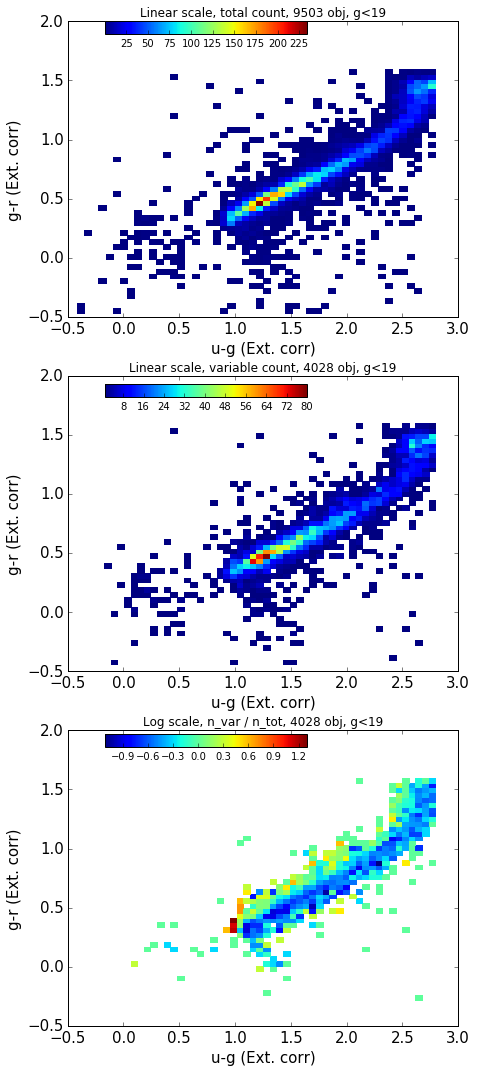

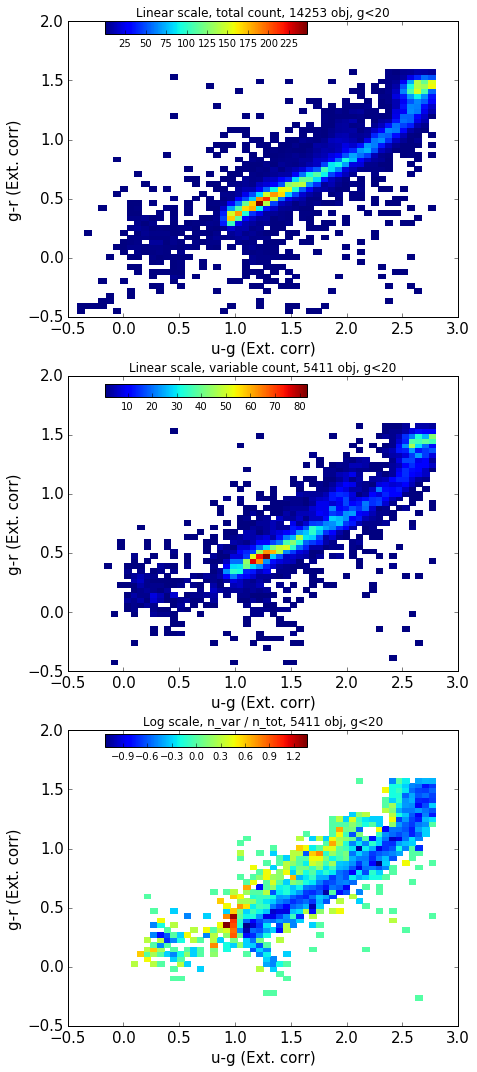

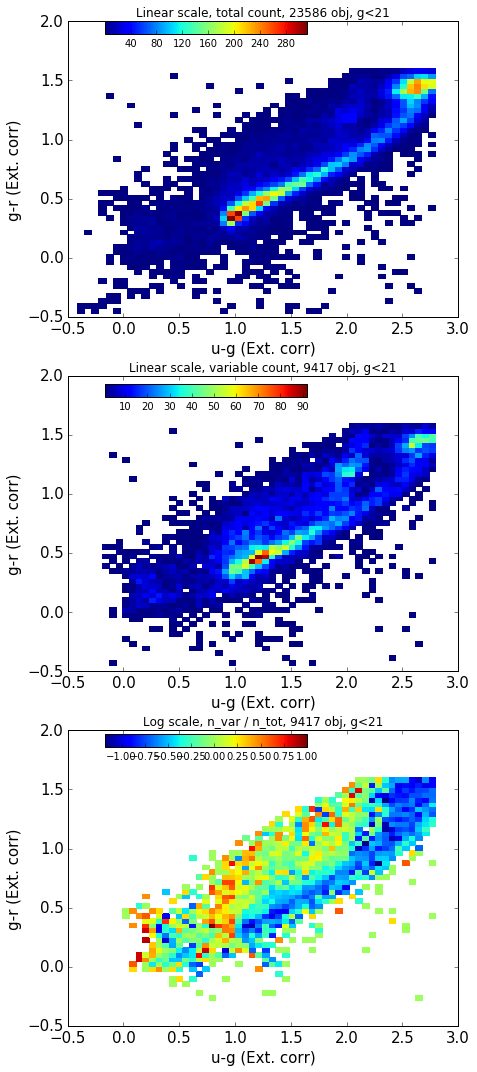

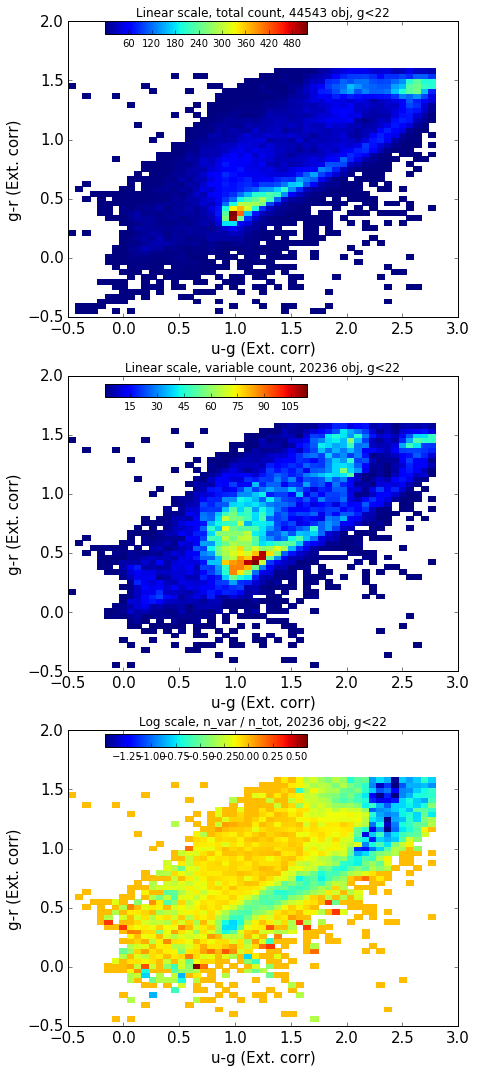

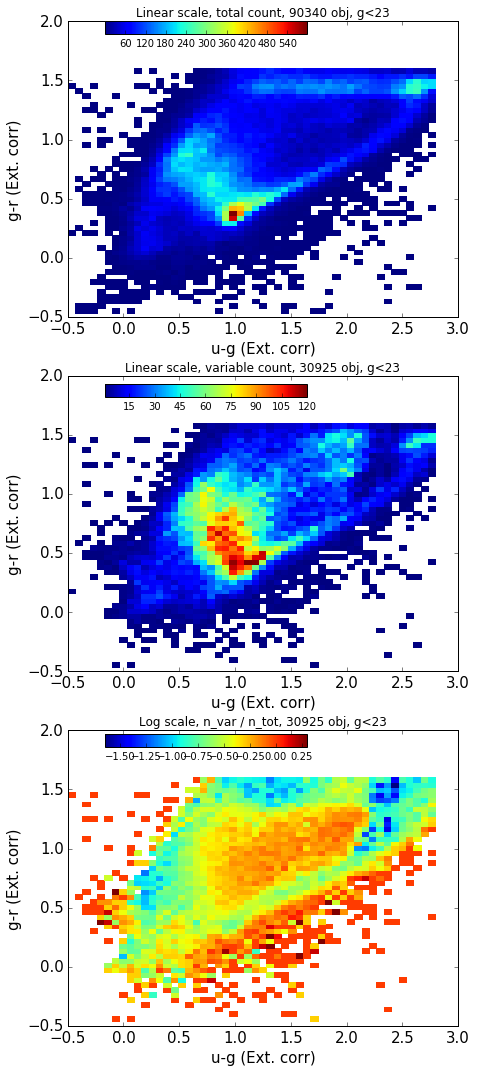

In [599]:
u = varPatchAll['upsfMean_corr'].values
g = varPatchAll['gpsfMean_corr'].values
r = varPatchAll['rpsfMean_corr'].values
for gmax in np.arange(19,24):
    mask_brightness = g < gmax
    mask_ug = ((u-g)<2.8) & ((u-g)>-0.5)
    mask_gr = ((g-r)<1.6) & ((g-r)>-0.5)
    mask_total = mask_ug & mask_gr & mask_brightness

    fig, ax = plt.subplots(3,1, figsize=(7,18))


    nObj = len(u[mask_total])
    H, xedges, yedges = np.histogram2d((u-g)[mask_total],(g-r)[mask_total], bins=50)
    H = np.rot90(H)
    H = np.flipud(H)
    # Mask zeros
    Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zeropltssssss
    # Plot 2D histogram using pcolor
    image = ax[0].pcolormesh(xedges,yedges,Hmasked, cmap='jet')
    #ax.plot(np.linspace(0,4), np.linspace(0,4), ls='--', lw=4)
    ax[0].set_xlabel('u-g (Ext. corr)', fontsize=15)
    ax[0].set_ylabel('g-r (Ext. corr)', fontsize=15)
    ax[0].set_title('Linear scale, total count, %d obj, g<%d'%(nObj,gmax))
    ax[0].tick_params(axis='both', which='major', labelsize=15) 

    #from mpl_toolkits.axes_grid1 import make_axes_locatable
    #divider = make_axes_locatable(plt.gca())
    # http://matplotlib.org/mpl_toolkits/axes_grid/users/overview.html 
    #colorbar_ax = divider.append_axes("right", "5%", pad="3%")
    colorbar_ax = fig.add_axes([0.2, 0.89, 0.4, 0.01])
    colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')
    #colorbar.set_ticks([0.5,1,1.5])
    #colorbar.set_ticklabels(['0.5','1', '1.5'])

    mask_variable = mask_total & mask_combined
    nObj = len(u[mask_variable])
    H, xedges, yedges = np.histogram2d((u-g)[mask_variable],(g-r)[mask_variable], bins=50)
    H = np.rot90(H)
    H = np.flipud(H)
    # Mask zeros
    Hmasked = np.ma.masked_where(H==0,H)
    # Mask pixels with a value of zeropltssssss
    # Plot 2D histogram using pcolor
    image = ax[1].pcolormesh(xedges,yedges, Hmasked, cmap='jet')
    #ax.plot(np.linspace(0,4), np.linspace(0,4), ls='--', lw=4)
    ax[1].set_xlabel('u-g (Ext. corr)', fontsize=15)
    ax[1].set_ylabel('g-r (Ext. corr)', fontsize=15)
    ax[1].set_title('Linear scale, variable count, %d obj, g<%d'%(nObj,gmax))
    ax[1].tick_params(axis='both', which='major', labelsize=15) 
    colorbar_ax = fig.add_axes([0.2, 0.61, 0.4, 0.01])
    colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')

    H1, xedges, yedges = np.histogram2d((u-g)[mask_total],(g-r)[mask_total], bins=50)
    H1 = np.rot90(H1)
    H1= np.flipud(H1)
    # Mask zeros
    Hmasked1 = np.ma.masked_where(H1==0,H1)

    H2, xedges, yedges = np.histogram2d((u-g)[mask_variable],(g-r)[mask_variable], bins=50)
    H2 = np.rot90(H2)
    H2 = np.flipud(H2)
    # Mask zeros
    Hmasked2 = np.ma.masked_where(H2==0,H2)

    Hmasked_ratio = Hmasked2 / Hmasked1 
    # Mask pixels with a value of zeropltssssss
    # Plot 2D histogram using pcolor
    image = ax[2].pcolormesh(xedges,yedges, np.log10(Hmasked_ratio), cmap='jet')
    ax[2].set_xlabel('u-g (Ext. corr)', fontsize=15)
    ax[2].set_ylabel('g-r (Ext. corr)', fontsize=15)
    ax[2].set_title('Log scale, n_var / n_tot, %d obj, g<%d'%(nObj,gmax))
    ax[2].tick_params(axis='both', which='major', labelsize=15) 
    colorbar_ax = fig.add_axes([0.2, 0.34, 0.4, 0.01])
    colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')


    #plt.tight_layout()

    # Saving the colorbar from being messed by the tight_layout()
    # http://matplotlib.org/users/tight_layout_guide.html

    fname = 'data_products/'+'Sesar_2007_Fig3_patch'+patch+'_g_lt_'+str(gmax)+'.png'
    plt.savefig(fname)
    print('Saved as %s '%fname)

# Sesar+2007 Fig.5, using ugr  and $\sigma(g) / \sigma(r)$

### Custom  2d binned statiscic : written from the scratch, does the job, but way too slow ! 

In [623]:
# Calculate the plot content ...

x, y = np.mgrid[slice(-0.5, 3.0, 0.05),
                slice(-0.5, 2.0, 0.05)]  # defines the grid for plotting 

z_count = np.zeros((70,50))  # store the count per bin
z_sigma = np.zeros((70,50))  # store the value of median sigma ratio per bin 

ug_grid = x[:,0] # take just the x_edges and y_edges 
gr_grid = y[0,:]

u = varPatchAll['upsfMean_corr'].values  #  quantities to be plotted  
g = varPatchAll['gpsfMean_corr'].values
r = varPatchAll['rpsfMean_corr'].values

mask_sigma_g = (varPatchAll['gsigmaFull'].values > 0)&(varPatchAll['gsigmaFull'].values <50)
mask_sigma_r = (varPatchAll['rsigmaFull'].values > 0)&(varPatchAll['rsigmaFull'].values <50)

gmax=20  # set the mag cutoff
mask_brightness = g < gmax

# Loop over bins in  u-g and g-r space 
for i in range(70-1):
    for j in range(50-1):
        mask_ug = ((u-g)<ug_grid[i+1]) & ((u-g)>ug_grid[i])
        mask_gr = ((g-r)<gr_grid[j+1]) & ((g-r)>gr_grid[j])
        mask_total = mask_ug & mask_gr & mask_brightness & mask_sigma_g & mask_sigma_r
        sigma_ratio = varPatchAll['gsigmaFull'][mask_total].values / varPatchAll['rsigmaFull'][mask_total].values
        count   = np.sum(mask_total)
        z_count[i,j] = count 
        if len(sigma_ratio) > 0 : 
            z_sigma[i,j] = np.median(sigma_ratio)
        else:
            z_sigma[i,j] = 0

\ excellent info about advanced plotting ....
https://python4mpia.github.io/plotting/advanced.html

Saved as data_products/Sesar_2007_Fig5_patch00_21_g_lt_20_handmade.png


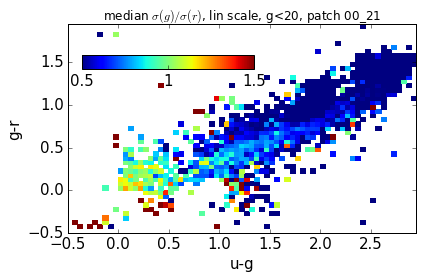

In [625]:
# Actually plotting the 2d histogram of sigma ratio binned in u-g vs g-r  

# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z_reduce  =  z_sigma[:-1, :-1]
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()

z_rot = np.rot90(z_reduce)
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)
#z_masked = np.ma.masked_where(z_reduce == 0 , z_reduce)
fig,ax = plt.subplots(1,1)
image = ax.pcolormesh(ug_grid,gr_grid,z_masked, cmap='jet',vmin=0.5, vmax=1.5)
ax.set_title('median '+r'$\sigma(g) / \sigma(r)$'+', lin scale, '+'g<'+str(gmax)+', patch '+patch)
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
colorbar_ax = fig.add_axes([0.2, 0.75, 0.4, 0.05])
colorbar = fig.colorbar(image, cax=colorbar_ax, orientation='horizontal')
colorbar.set_ticks([0.5,1,1.5])
colorbar.set_ticklabels(['0.5','1', '1.5'])

# Various arguments for the colorbar... 
#ColorbarBase(ax, cmap=None, norm=None, alpha=None, values=None, boundaries=None, 
#             orientation='vertical', ticklocation='auto', extend='neither', 
#             spacing='uniform', ticks=None, format=None, drawedges=False, filled=True, 
#             extendfrac=None, extendrect=False, label='')
# http://matplotlib.org/api/colorbar_api.html#matplotlib.colorbar.Colorbar 

ax.set_xlabel('u-g', fontsize=15)
ax.set_ylabel('g-r', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15) 
colorbar_ax.tick_params(labelsize=15)
name =  'data_products/'+'Sesar_2007_Fig5_patch'+patch+'_g_lt_'+str(gmax)+'_handmade.png'
plt.tight_layout()
plt.savefig(name)
print('Saved as %s'%name)

### Out of the box binned_statistic_2d : works very well ! 

In [ ]:
from scipy.stats import binned_statistic_2d

http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.binned_statistic_2d.html

On this plot there are 13734 out of 487054 total points in this patch 
Saved as data_products/Sesar_2007_Fig5_patch00_21_g_lt_20.5_scipy.png


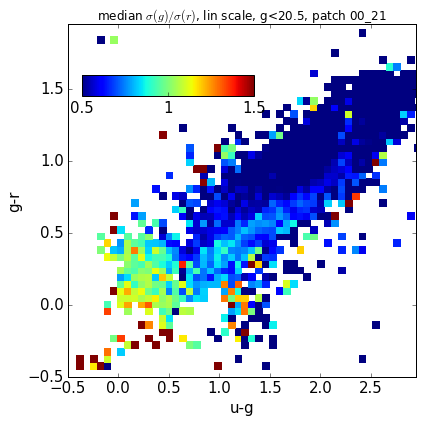

In [633]:
%matplotlib inline

u = varPatchAll['upsfMean_corr'].values
g = varPatchAll['gpsfMean_corr'].values
r = varPatchAll['rpsfMean_corr'].values
sigma_g = varPatchAll['gsigmaFull'].values
sigma_r = varPatchAll['rsigmaFull'].values
mask_sigma_g = (sigma_g > 0)&(sigma_g <50)
mask_sigma_r = (sigma_r > 0)&(sigma_r <50)

gmax=20.5
mask_brightness = g < gmax
mask_ug = ((u-g)<3) & ((u-g)>-0.5)
mask_gr = ((g-r)<2) & ((g-r)>-0.5)
mask_total = mask_ug & mask_gr & mask_brightness & mask_sigma_g & mask_sigma_r

print('On this plot there are %d out of %d total points in this patch '%(np.sum(mask_total), len(mask_total)))
sigma_ratio = sigma_g[mask_total] / sigma_r[mask_total]
u_g = (u-g)[mask_total]
g_r = (g-r)[mask_total]

# calculate the median statistic on sigma_ratio binned according to  u-g vs g-r 
stats = binned_statistic_2d(x=u_g, y=g_r, values=sigma_ratio, statistic='median', bins=50)
z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]

# replace all nan's by 0 ...
z_sigma[np.isnan(z_sigma)] =0 

z_reduce  =  z_sigma # [:-1, :-1] no need to reduce here because x_edges are already given with the right size 
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()

z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)  # mask out zeros... 

# make a figure 
fig,ax = plt.subplots(1,1, figsize=(6,6))
image = ax.pcolormesh(x_edges, y_edges ,z_masked, cmap='jet',vmin=0.5, vmax=1.5)
ax.axis([x.min(), x.max(), y.min(), y.max()])
ax.set_title('median '+r'$\sigma(g) / \sigma(r)$'+', lin scale, '+'g<'+str(gmax)+', patch '+patch)
colorbar_ax = fig.add_axes([0.2, 0.77, 0.4, 0.05])
colorbar = fig.colorbar(image, cax=colorbar_ax, orientation='horizontal')
colorbar.set_ticks([0.5,1,1.5])
colorbar.set_ticklabels(['0.5','1', '1.5'])

ax.set_xlabel('u-g', fontsize=15)
ax.set_ylabel('g-r', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15) 
colorbar_ax.tick_params(labelsize=15)
name =  'data_products/'+'Sesar_2007_Fig5_patch'+patch+'_g_lt_'+str(gmax)+'_scipy.png'
plt.tight_layout()
plt.savefig(name)
print('Saved as %s'%name)

http://thomas-cokelaer.info/blog/2014/05/matplotlib-difference-between-pcolor-pcolormesh-and-imshow/

https://github.com/olgabot/prettyplotlib/wiki/scatter-and-pcolormesh:-Motivating-examples

https://python4mpia.github.io/plotting/advanced.html

http://matplotlib.org/examples/pylab_examples/pcolor_demo.html


In [174]:
u = varPatchAll['upsfMean_corr'].values
g = varPatchAll['gpsfMean_corr'].values


In [188]:
varPatchAll['gsigmaFullMag'] = 0

(array([  1.74600000e+03,   8.80000000e+01,   2.00000000e+01,
          8.00000000e+00,   9.00000000e+00,   5.00000000e+00,
          3.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00]),
 array([   0.50003051,   32.01134404,   63.52265756,   95.03397109,
         126.54528462,  158.05659815,  189.56791168,  221.07922521,
         252.59053874,  284.10185227,  315.61316579]),
 <a list of 10 Patch objects>)

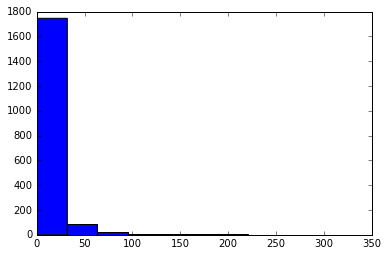

In [196]:
s= varPatchAll['gsigmaFull'].values
plt.hist(s[s>0.5])

In [204]:
np.sum(s>0.001)

206898

In [192]:
varPatchAll['gsigmaFullMag'][m]

0         25.017297
1         25.105561
3         25.079769
4         24.721277
5         25.395931
6         25.963041
9         25.566799
10        24.558264
11        25.361952
12        25.834372
13        26.018388
14        25.647683
15        24.995605
16        25.074693
19        24.679812
22        26.040258
23        24.698596
24        23.930196
26        25.716892
28        25.469578
29        25.929335
31        24.400276
33        25.514287
34        26.268459
35        24.772968
36        24.361092
37        25.373767
40        24.960499
41        23.828290
42        24.785976
            ...    
486967    24.867144
486968    25.080586
486971    25.708468
486972    21.725959
486975    26.643633
486978    23.830055
486982    26.123581
486985    25.796979
486986    24.878599
486989    25.483817
486994    24.155117
486997    26.875661
486999    26.559567
487001    25.139272
487004    25.644011
487008    24.900569
487009    26.576715
487015    22.512838
487016    23.200271


In [ ]:
# Say that variable objects are varMask 

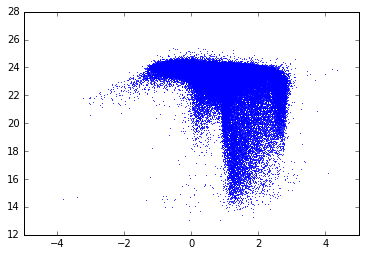

In [120]:
%matplotlib inline
plt.scatter(u-g,u, lw=0, s=1)

In [143]:
len(g[np.isnan(g)])

3544

In [144]:
len(g)

490598

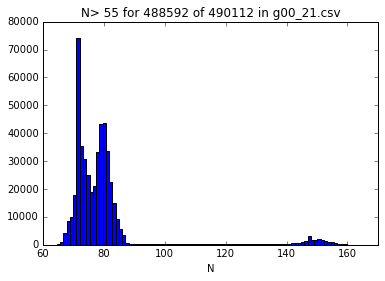

In [5]:
%matplotlib inline
xMin = 55
m = varMetricsFull['N'] > xMin
plt.hist(varMetricsFull['N'][m], bins=100)
plt.title('N> %d for %d of %d in g00_21.csv'%(xMin, np.sum(m),len(m) ))
plt.xlim(60,170)
plt.xlabel('N')
#plt.savefig('Varg00_21_1000_bootstraps_hist_N.png')

In [6]:
hist, bin_edges = np.histogram(varMetricsFull['N'][varMetricsFull['N'].values> 55].values, bins=np.arange(56,163), density=False)
bin_cen = (bin_edges[:-1] + bin_edges[1:])/2



In [7]:
len(varMetricsFull['N'][varMetricsFull['N'].values> 55].values)

488592

In [8]:
# time_hist is in miliseconds 
N = [72,144]
time = [9.02, 15.9]  
p = np.polyfit(N,time,deg=1)
time_hist = p[0] + p[1] * bin_cen
ttl_time = np.sum(hist*time_hist) / (1000 * 60 * 60 )
print('For 1000 bootstraps it took %.2f hours' % ttl_time)
# thus I get that it roughly took  22.85 hours with  N = 1000 bootstraps.... 

N = [72,144]
time = [62.2, 122]
p = np.polyfit(N,time,deg=1)
time_hist = p[0] + p[1] * bin_cen
ttl_time = np.sum(hist*time_hist) / (1000 * 60 * 60 )
print('For 10000 bootstraps it took %.2f hours' % ttl_time)

For 1000 bootstraps it took 23.31 hours
For 10000 bootstraps it took 26.24 hours


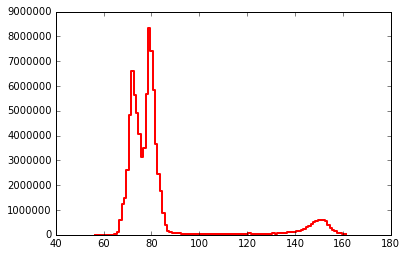

In [9]:
# N pts per lightcurve and time of calculation for N=1000 bootstraps
N = [72,144]
time = [9.02, 15.9]
p = np.polyfit(N,time,deg=1)
time_hist = p[0] + p[1] * bin_cen
fig,ax = plt.subplots()
#ax.plot(bin_cen, time_hist, color = 'blue', ls='steps', lw=2)
ax.plot(bin_cen, hist*time_hist, color='red', ls='steps', lw=2)

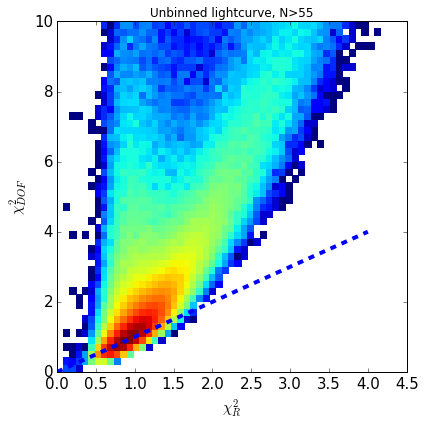

In [9]:
%matplotlib inline
# Plot some results : full LC : 
fig, ax = plt.subplots(figsize=(6,6))
xMin = 55
m4 = varMetricsFull['N'].values  > xMin
lim = 10
m1=varMetricsFull[m4]['chi2R'].values<lim
m2=varMetricsFull[m4]['chi2DOF'].values<lim
m= m1*m2  # logical and 

H, xedges, yedges = np.histogram2d(varMetricsFull[m4]['chi2R'].values[m],varMetricsFull[m4]['chi2DOF'].values[m], bins=50)
H = np.rot90(H)
H = np.flipud(H)
# Mask zeros
Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zeropltssssss
# Plot 2D histogram using pcolor
ax.pcolormesh(xedges,yedges,np.log10(Hmasked), cmap='jet')
ax.plot(np.linspace(0,4), np.linspace(0,4), ls='--', lw=4)
ax.set_xlabel(r'$\chi^{2}_{R}$', fontsize=15)
ax.set_ylabel(r'$\chi^{2}_{DOF}$', fontsize=15)
ax.set_title('Unbinned lightcurve, N>%d'%xMin)
#ax.set_xlim(0,lim)
#ax.set_ylim(0,lim)
ax.tick_params(axis='both', which='major', labelsize=15) 
plt.tight_layout()
plt.savefig('Vari00_21_1000_bootstraps_Chi2R_vs_Chi2DOF_yMax_10.png')

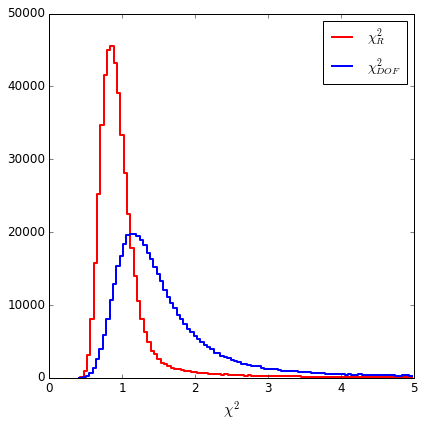

In [11]:
%matplotlib inline 

fig,ax = plt.subplots(1,1 , figsize=(6,6))

nbins=100

nMin = 55
m4 = varMetricsFull['N'].values  > nMin

chi2Rlim = 5
m=varMetricsFull[m4]['chi2R'].values< chi2Rlim
hist, bin_edges = np.histogram(varMetricsFull[m4]['chi2R'].values[m], bins=nbins, density=False)
bin_cen = (bin_edges[:-1] + bin_edges[1:])/2
ax.plot(bin_cen, hist, color = 'red', ls='steps', lw=2, label=r'$\chi^{2}_{R}$')
#ax.legend(fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)


chi2DOFlim = 5
m=varMetricsFull[m4]['chi2DOF'].values<chi2DOFlim
hist, bin_edges = np.histogram(varMetricsFull[m4]['chi2DOF'].values[m], bins=nbins, density=False)
bin_cen = (bin_edges[:-1] + bin_edges[1:])/2
ax.plot(bin_cen, hist, color = 'blue', ls='steps', lw=2, label=r'$\chi^{2}_{DOF}$')
ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel(r'$\chi^{2}$', fontsize=15)
plt.tight_layout()
#fig.subplots_adjust(wspace=0.36, hspace=0.26, left=0.12, right=0.94, bottom=0.10, top=0.95)
plt.savefig('Varg00_21_1000_bootstraps_Chi2R_vs_Chi2DOF_hist.png')

In [5]:
nMin = 55
m4 = varMetricsFull['N'].values  > nMin
np.sum(varMetricsFull['sigmaFull'][m4] > 100)
print('N> %d for %d of %d in g00_21.csv'%(nMin, np.sum(m4),len(m4) ))

N> 55 for 489320 of 490369 in g00_21.csv


In [11]:
nMin = 55
m4 = varMetricsFull['N'].values  > nMin

sigMax = 1

ma = 0<varMetricsFull[m4]['sigmaFull']
mb = varMetricsFull[m4]['sigmaFull']<sigMax
m1 = ma*mb
varMetricsSig  = varMetricsFull[m4][m1]
print(' 0 < sigmaFull < %d for %d of %d in N>55 objects in g00_21.csv'%(sigMax, np.sum(m1),len(m1) ))

 0 < sigmaFull < 1 for 326669 of 488592 in N>55 objects in g00_21.csv


/astro/apps6/anaconda2.0/lib/python2.7/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


In [12]:
np.sum(varMetricsFull[m4]['sigmaFull']==0 )

161070

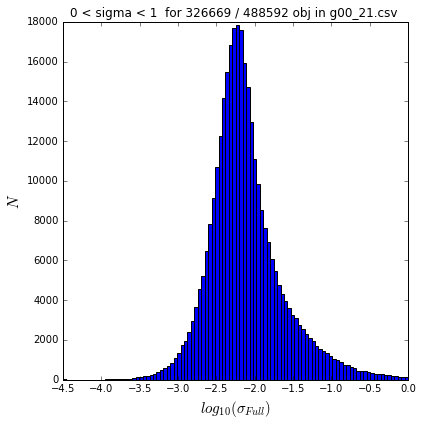

In [13]:
%matplotlib inline 
fig,ax = plt.subplots(1,1, figsize=(6,6))
ax.hist(np.log10(varMetricsSig['sigmaFull']), bins=100)
ax.set_ylabel(r'$N$',fontsize=15)
ax.set_xlabel(r'$log_{10}(\sigma_{Full})$', fontsize=15)
ax.set_title(r'0 < sigma < %d  for %d / %d obj in g00_21.csv ' %(sigMax, np.sum(m1),len(m1)), fontsize=12)
plt.tight_layout()

plt.savefig('Varg00_21_1000_bootstraps_sigma.png')

In [16]:
len(varMetricsSig['muFull'])

210376

In [17]:
max(varMetricsSig['sigmaFull'])

0.99840272222499993

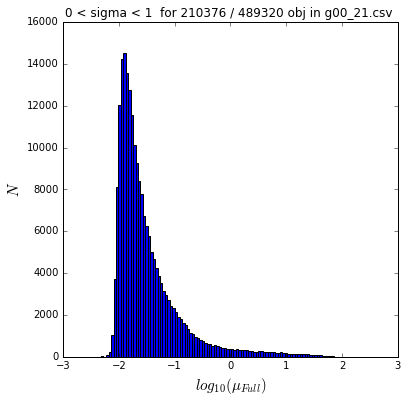

In [18]:
%matplotlib inline 
fig,ax = plt.subplots(1,1, figsize=(6,6))
ax.hist(np.log10(np.array(varMetricsSig['muFull'].values).astype(float)), bins=100)
ax.set_title(r'0 < sigma < %d  for %d / %d obj in g00_21.csv ' %(sigMax, np.sum(m1),len(m1)), fontsize=12)
ax.set_ylabel(r'$N$',fontsize=15)
ax.set_xlabel(r'$log_{10}(\mu_{Full})$', fontsize=15)
plt.savefig('Varg00_21_1000_bootstraps_mu.png')

In [19]:
# Select variable candidates  

m1 = (varMetricsFull['sigmaFull'] > 0).values  # 234883
m2 =  (varMetricsFull['chi2DOF'] > 1).values   # 346886
m3 = (varMetricsFull['chi2R'] > 1).values      # 172602
m= np.ma.mask_or(m3, np.ma.mask_or(m1,m2))
print('Out of %d objects,:\n'%len(m)) 
print('%d fulfill  sigma>0 OR chi2R>1 OR chi2DOF>1' % ( np.sum(m)))

# The  '3 sigma' definition (more strict) ...
N = varMetricsFull['N'] #  number of pts per lightcurve 
m4 = varMetricsFull['chi2DOF'] > (1 + 3.0 * np.sqrt(2 / N )) ##  170517
m5 = varMetricsFull['chi2R'] > (1 + 3.0 * np.sqrt(2 / N))   ## 37464
# one or the other   170534
print('Also, %d fulfill chi2R>1+3*sqrt(2/n) OR chi2DOF>1+3*sqrt(2/n) ' % (np.sum(m4|m5)))
print('Also, %d fulfill sigma > 0 OR  chi2R>1+3*sqrt(2/n) OR chi2DOF>1+3*sqrt(2/n) ' % (np.sum(m1|m4|m5)))
 # 265981   sigma OR  chi2R  OR chi2DOF 
print('Also, %d fulfill sigma > 0 AND [ chi2R>1+3*sqrt(2/n) OR chi2DOF>1+3*sqrt(2/n) ]' % (np.sum(m1*(m4|m5))))
#

m = m1*(m4|m5)
# Grab only those rows that correspond to variable objects...

varMetricsVarOnly = varMetricsFull[m]

Out of 490369 objects,:

428295 fulfill  sigma>0 OR chi2R>1 OR chi2DOF>1
Also, 235462 fulfill chi2R>1+3*sqrt(2/n) OR chi2DOF>1+3*sqrt(2/n) 
Also, 296312 fulfill sigma > 0 OR  chi2R>1+3*sqrt(2/n) OR chi2DOF>1+3*sqrt(2/n) 
Also, 151035 fulfill sigma > 0 AND [ chi2R>1+3*sqrt(2/n) OR chi2DOF>1+3*sqrt(2/n) ]


/Users/chris/anaconda/lib/python3.5/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


NameError: name 'varMetricsVarOnly' is not defined

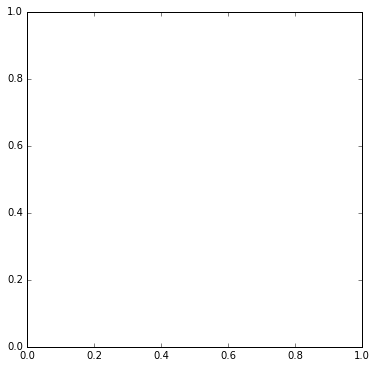

In [49]:
%matplotlib inline
# Plot some results : full LC : 
fig, ax = plt.subplots(figsize=(6,6))
xMin = 55
m4 = varMetricsVarOnly['N'].values  > xMin
lim = 10
m1=varMetricsVarOnly[m4]['chi2R'].values<lim
m2=varMetricsVarOnly[m4]['chi2DOF'].values<lim
m= m1*m2  # logical and 

H, xedges, yedges = np.histogram2d(varMetricsVarOnly[m4]['chi2R'].values[m],varMetricsVarOnly[m4]['chi2DOF'].values[m], bins=50)
H = np.rot90(H)
H = np.flipud(H)
# Mask zeros
Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zeropltssssss
# Plot 2D histogram using pcolor
ax.pcolormesh(xedges,yedges,np.log10(Hmasked), cmap='jet')
ax.plot(np.linspace(0,4), np.linspace(0,4), ls='--', lw=4)
ax.set_xlabel(r'$\chi^{2}_{R}$', fontsize=15)
ax.set_ylabel(r'$\chi^{2}_{DOF}$', fontsize=15)
ax.set_title('Unbinned lightcurve, N>%d, g00_21'%xMin)
#ax.set_xlim(0,lim)
#ax.set_ylim(0,lim)
ax.tick_params(axis='both', which='major', labelsize=15) 
plt.tight_layout()
plt.savefig('Varg00_21_10000_bootstraps_Chi2R_vs_Chi2DOF_yMax_10_VarOnly.png')

## Group by number of observation points... 

This plot has 486262 of 490369  objects in g00_21.csv 


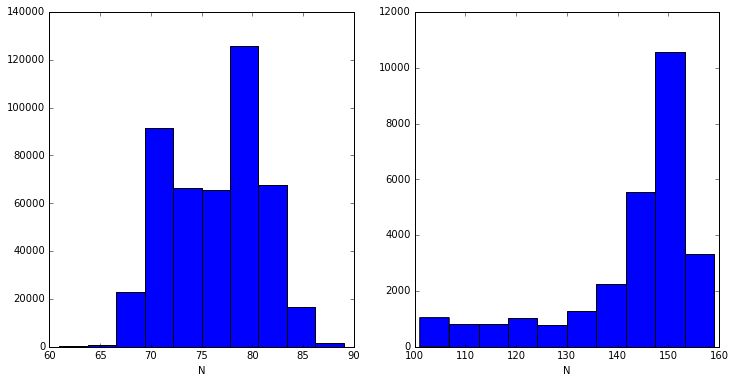

In [17]:
# Split all objects by the number of observation points ... 
# Nsmall  Nlarge 

%matplotlib inline


fig,ax = plt.subplots(1,2, figsize=(12,6))

m1 = (  60 < varMetricsFull['N'] ) & ( varMetricsFull['N'] < 90)
n1 = len(varMetricsFull['N'][m1].values)
ax[0].hist(varMetricsFull['N'][m1])
#plt.title('N> %d for %d of %d in g00_21.csv'%(xMin, np.sum(m),len(m) ))
#plt.xlim(60,170)
ax[0].set_xlabel('N')

m2 = (  100 < varMetricsFull['N'] ) & ( varMetricsFull['N'] < 160)
n2 = len(varMetricsFull['N'][m2].values)
ax[1].hist(varMetricsFull['N'][m2])
ax[1].set_xlabel('N')

print('This plot has %d of %d  objects in g00_21.csv '%(n1+n2, len(varMetricsFull['N'].values) ))

In [52]:
m1 = (  60 < varMetricsFull['N'].values ) & ( varMetricsFull['N'].values < 90)
print(len(varMetricsFull[m1]['N'].values))
mR = varMetricsFull[m1]['chi2R'].values < 10 
print(np.sum(mR))
mDOF=varMetricsFull[m1]['chi2DOF'].values<10
print(np.sum(mDOF))
m = mR & mDOF
print(len(varMetricsFull[m1]['N'].values[m]))


458781
458025
443775
443775


In [45]:
np.sum(mDOF)

443775

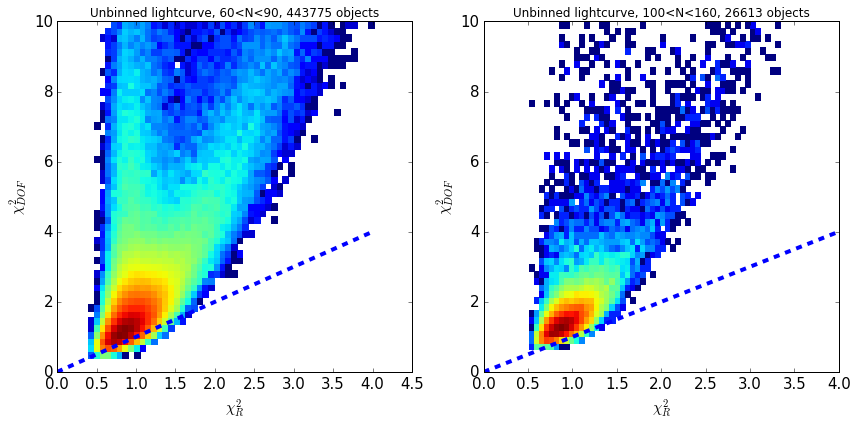

In [55]:
%matplotlib inline
# Plot some results : full LC : 
fig, ax = plt.subplots(1,2, figsize=(12,6))

lim = 10
# m1 selects objects with  N_min < N < N_max , 
# as specified above 


# left : m1   (small Number of obs )
m1 = (  60 < varMetricsFull['N'].values ) & ( varMetricsFull['N'].values < 90)
mR = varMetricsFull[m1]['chi2R'].values < lim
mDOF=varMetricsFull[m1]['chi2DOF'].values < lim
m= mR & mDOF  # logical and 
nObj = len(varMetricsFull[m1]['chi2R'].values[m])
H, xedges, yedges = np.histogram2d(varMetricsFull[m1]['chi2R'].values[m],varMetricsFull[m1]['chi2DOF'].values[m], bins=50)
H = np.rot90(H)
H = np.flipud(H)
# Mask zeros
Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zeropltssssss
# Plot 2D histogram using pcolor
ax[0].pcolormesh(xedges,yedges,np.log10(Hmasked), cmap='jet')
ax[0].plot(np.linspace(0,4), np.linspace(0,4), ls='--', lw=4)
ax[0].set_xlabel(r'$\chi^{2}_{R}$', fontsize=15)
ax[0].set_ylabel(r'$\chi^{2}_{DOF}$', fontsize=15)
ax[0].set_title('Unbinned lightcurve, %d<N<%d, %d objects'%(60,90,nObj))
#ax.set_xlim(0,lim)
#ax.set_ylim(0,lim)
ax[0].tick_params(axis='both', which='major', labelsize=15) 


# right  : m2 : large N points 
m2 = (  100 < varMetricsFull['N'].values ) & ( varMetricsFull['N'].values < 160)
mR = varMetricsFull[m2]['chi2R'].values < lim
mDOF=varMetricsFull[m2]['chi2DOF'].values < lim
m= mR & mDOF  # logical and 
nObj = len(varMetricsFull[m2]['chi2R'].values[m])
H, xedges, yedges = np.histogram2d(varMetricsFull[m2]['chi2R'].values[m],varMetricsFull[m2]['chi2DOF'].values[m], bins=50)
H = np.rot90(H)
H = np.flipud(H)
# Mask zeros
Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zeropltssssss
# Plot 2D histogram using pcolor
ax[1].pcolormesh(xedges,yedges,np.log10(Hmasked), cmap='jet')
ax[1].plot(np.linspace(0,4), np.linspace(0,4), ls='--', lw=4)
ax[1].set_xlabel(r'$\chi^{2}_{R}$', fontsize=15)
ax[1].set_ylabel(r'$\chi^{2}_{DOF}$', fontsize=15)
ax[1].set_title('Unbinned lightcurve, %d<N<%d, %d objects'%(100,160, nObj))
#ax.set_xlim(0,lim)
#ax.set_ylim(0,lim)
ax[1].tick_params(axis='both', which='major', labelsize=15) 

plt.tight_layout()
#plt.savefig('Varg00_21_1000_bootstraps_Chi2R_vs_Chi2DOF_yMax_10.png')

In [63]:
# First, use only sigma between d 1 , other values are not really very informative... 
m1 = (  60 < varMetricsFull['N'].values ) & ( varMetricsFull['N'].values < 90)
mSig = (varMetricsFull[m1]['sigmaFull'].values < 1) & (varMetricsFull[m1]['sigmaFull'].values > 0)
varMetricsSig = varMetricsFull[m1][mSig]

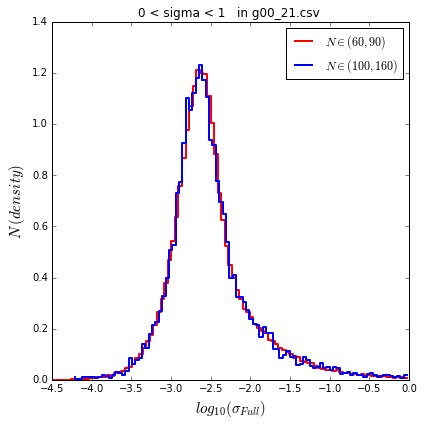

In [20]:
fig,ax = plt.subplots( figsize=(6,6))
nbins=100

m1 = (  60 < varMetricsFull['N'].values ) & ( varMetricsFull['N'].values < 90)
mSig = (varMetricsFull['sigmaFull'].values < 1) & (varMetricsFull['sigmaFull'].values > 0)
m = m1&mSig
varMetricsSig = varMetricsFull[m]
hist, bin_edges = np.histogram(np.log10(varMetricsSig['sigmaFull']), bins=nbins, density=True)
bin_cen = (bin_edges[:-1] + bin_edges[1:])/2
ax.plot(bin_cen, hist, color = 'red', ls='steps', lw=2, label=r'$N\in(60,90)$')

m2 = (  100 < varMetricsFull['N'].values ) & ( varMetricsFull['N'].values < 160)
mSig = (varMetricsFull['sigmaFull'].values < 1) & (varMetricsFull['sigmaFull'].values > 0)
m = m2&mSig
varMetricsSig = varMetricsFull[m]
hist, bin_edges = np.histogram(np.log10(varMetricsSig['sigmaFull']), bins=nbins, density=True)
bin_cen = (bin_edges[:-1] + bin_edges[1:])/2
ax.plot(bin_cen, hist, color = 'blue', ls='steps', lw=2, label=r'$N\in(100,160)$')

ax.set_ylabel(r'$N \,(density)$',fontsize=15)
ax.set_xlabel(r'$log_{10}(\sigma_{Full})$', fontsize=15)
ax.set_title(r'0 < sigma < 1   in g00_21.csv ' , fontsize=12)

#ax.set_xlim(-4.5,0)

ax.legend()

#ax[0].hist(np.log10(varMetricsSig['sigmaFull']), bins=100)

plt.tight_layout()
plt.savefig('Varg00_21_1000_bootstraps_sigma_hist_N_groups.png')

In [12]:
np.array(varMetricsSig['muFull'].values).astype(float)*1e27

array([  1.25934788e+25,   5.91039437e+26,   1.04757295e+25, ...,
         2.70294880e+25,   2.38215180e+25,   2.05027555e+25])

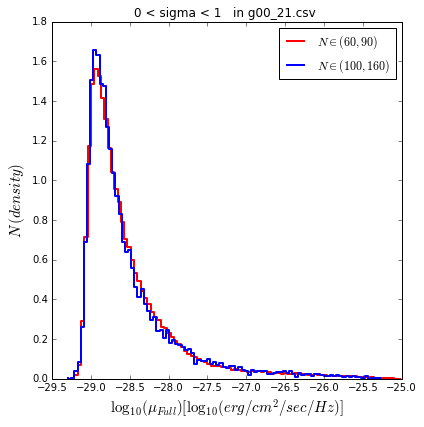

In [18]:
fig,ax = plt.subplots( figsize=(6,6))
nbins=100

m1 = (  60 < varMetricsFull['N'].values ) & ( varMetricsFull['N'].values < 90)
mSig = (varMetricsFull['sigmaFull'].values < 1) & (varMetricsFull['sigmaFull'].values > 0)
m = m1&mSig
varMetricsSig = varMetricsFull[m]
hist, bin_edges = np.histogram(np.log10(1e-27*np.array(varMetricsSig['muFull'].values).astype(float)), bins=nbins, density=True)
bin_cen = (bin_edges[:-1] + bin_edges[1:])/2
ax.plot(bin_cen, hist, color = 'red', ls='steps', lw=2, label=r'$N\in(60,90)$')

m2 = (  100 < varMetricsFull['N'].values ) & ( varMetricsFull['N'].values < 160)
mSig = (varMetricsFull['sigmaFull'].values < 1) & (varMetricsFull['sigmaFull'].values > 0)
m = m2&mSig
varMetricsSig = varMetricsFull[m]
hist, bin_edges = np.histogram(np.log10(1e-27*np.array(varMetricsSig['muFull'].values).astype(float)), bins=nbins, density=True)
bin_cen = (bin_edges[:-1] + bin_edges[1:])/2
ax.plot(bin_cen, hist, color = 'blue', ls='steps', lw=2, label=r'$N\in(100,160)$')

ax.set_ylabel(r'$N \,(density)$',fontsize=15)
ax.set_xlabel(r'$\log_{10}(\mu_{Full}) \, [\log_{10}(erg/cm^{2}/sec/Hz )]$', fontsize=15)
ax.set_title(r'0 < sigma < 1   in g00_21.csv ' , fontsize=12)

#ax.set_xlim(-4.5,0)

ax.legend()

#ax[0].hist(np.log10(varMetricsSig['sigmaFull']), bins=100)

plt.tight_layout()

#ax.hist(np.log10(np.array(varMetricsSig['muFull'].values).astype(float)), bins=100)
#ax.set_title(r'0 < sigma < %d  for %d / %d obj in g00_21.csv ' %(sigMax, np.sum(m1),len(m1)), fontsize=12)
#ax.set_ylabel(r'$N$',fontsize=15)
#ax.set_xlabel(r'$log_{10}(\mu_{Full})$', fontsize=15)

plt.savefig('Varg00_21_1000_bootstraps_mu_hist_N_groups.png')

In comparison, I see nothing special in the structue of objects observed multiple times as opposed to those observed only few times...  (the plot is normalized so that the area under the histogram is 1  : np.sum(hist * (bin_edges[1] - bin_edges[0])) = 1 )

## Group by log10(sigma) and g magnitude 

(array([  7.20000000e+01,   5.16000000e+02,   1.11600000e+03,
          1.87400000e+03,   3.14000000e+03,   4.77300000e+03,
          1.02850000e+04,   3.11050000e+04,   1.13627000e+05,
          3.23861000e+05]),
 array([ 10.67860337,  12.10490633,  13.5312093 ,  14.95751226,
         16.38381523,  17.8101182 ,  19.23642116,  20.66272413,
         22.08902709,  23.51533006,  24.94163302]),
 <a list of 10 Patch objects>)

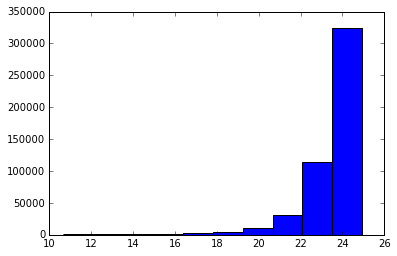

In [91]:
%matplotlib inline 
plt.hist(varMetricsFull['psfMean'].values)

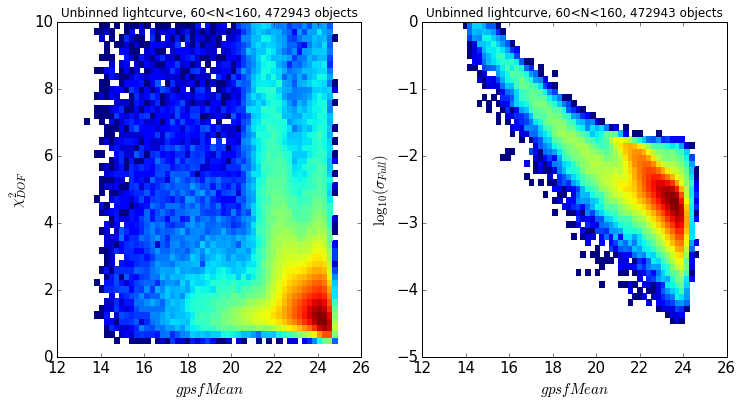

In [21]:
fig, ax = plt.subplots(1,2, figsize=(12,6))

lim = 10
# m1 selects objects with  N_min < N < N_max , 
# as specified above 

# left : m1   (small Number of obs )
#m1 = (  60 < varMetricsFull['N'].values ) & ( varMetricsFull['N'].values < 90)
m1 = (  60 < varMetricsFull['N'].values ) & ( varMetricsFull['N'].values < 160)
mR = varMetricsFull['chi2R'].values < lim
mDOF=varMetricsFull['chi2DOF'].values < lim
mChi2= mR & mDOF  # logical and 
m = mChi2&m1
nObj = len(varMetricsFull['chi2R'].values[m])
H, xedges, yedges = np.histogram2d(varMetricsFull['psfMean'].values[m],varMetricsFull['chi2DOF'].values[m], bins=50)
H = np.rot90(H)
H = np.flipud(H)
# Mask zeros
Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zeropltssssss
# Plot 2D histogram using pcolor
ax[0].pcolormesh(xedges,yedges,np.log10(Hmasked), cmap='jet')
#ax.plot(np.linspace(0,4), np.linspace(0,4), ls='--', lw=4)
ax[0].set_xlabel(r'$gpsfMean$', fontsize=15)
ax[0].set_ylabel(r'$\chi^{2}_{DOF}$', fontsize=15)
ax[0].set_title('Unbinned lightcurve, %d<N<%d, %d objects'%(60,160,nObj))
#ax.set_xlim(0,lim)
#ax.set_ylim(0,lim)
ax[0].tick_params(axis='both', which='major', labelsize=15) 

mSig = (varMetricsFull['sigmaFull'].values < 1) & (varMetricsFull['sigmaFull'].values > 0)
m = m & mSig
H, xedges, yedges = np.histogram2d(varMetricsFull['psfMean'].values[m],np.log10(varMetricsFull['sigmaFull'].values[m]), bins=50)
H = np.rot90(H)
H = np.flipud(H)
# Mask zeros
Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zeropltssssss
# Plot 2D histogram using pcolor
ax[1].pcolormesh(xedges,yedges,np.log10(Hmasked), cmap='jet')
#ax.plot(np.linspace(0,4), np.linspace(0,4), ls='--', lw=4)
ax[1].set_xlabel(r'$gpsfMean$', fontsize=15)
ax[1].set_ylabel(r'$\log_{10}{(\sigma_{Full})}$', fontsize=15)
ax[1].set_title('Unbinned lightcurve, %d<N<%d, %d objects'%(60,160,nObj))
#ax.set_xlim(0,lim)
#ax.set_ylim(0,lim)
ax[1].tick_params(axis='both', which='major', labelsize=15) 

plt.savefig('Varg00_21_1000_bootstraps_chi2DOF_sigFull_gMag.png')


Since it seems that Nobs does not affect chi2 nor sigma or mu properties,  in this exercise I only bin by sigmaFull,  and then by magnitudes 

In [8]:
m1 = (  60 < varMetricsFull['N'].values ) & ( varMetricsFull['N'].values < 160)
mR = varMetricsFull['chi2R'].values < lim
mDOF=varMetricsFull['chi2DOF'].values < lim
mChi2= mR & mDOF  # logical and 
mPre = mChi2&m1 

i=0
j=0

mSig = (np.log10(varMetricsFull['sigmaFull'].values) < log10SigLims[i+1] ) & \
       (np.log10(varMetricsFull['sigmaFull'].values) > log10SigLims[i])
mMag = (varMetricsFull['psfMean'].values < gMagLims[j+1]) & \
       (varMetricsFull['psfMean'].values > gMagLims[j])
mPanel = mSig & mMag
m = mPre & mPanel
        
        
np.sum(m)

2

2110

In [9]:
m1 = (  60 < varMetricsFull['N'].values ) & ( varMetricsFull['N'].values < 160)
mR = varMetricsFull['chi2R'].values < lim
mDOF=varMetricsFull['chi2DOF'].values < lim
mChi2= mR & mDOF  # logical and 
mComm = mChi2&m1
#print(np.sum(mComm))
for i in range(x):
    
    for j in range(y):
        
        mSig = (np.log10(varMetricsFull['sigmaFull'].values) < log10SigLims[i+1] ) & \
              (np.log10(varMetricsFull['sigmaFull'].values) > log10SigLims[i])
        mMag = (varMetricsFull['psfMean'].values < gMagLims[j+1]) & \
               (varMetricsFull['psfMean'].values > gMagLims[j])
        print('%.2f < log10(Sigma) < %.2f : %d'%(log10SigLims[i],log10SigLims[i+1],np.sum(mSig)))
        print('%.2f < gpsfMean (g mag) < %.2f : %d'%(gMagLims[j], gMagLims[j+1],np.sum(mMag))) 
        mPanel = mSig & mMag
        print('Set intersection: %d'%np.sum(mPanel))
        mPanel = mPanel & mComm
        print('Impose N and chi2 cut: %d'%np.sum(mPanel))
        print('\n')

NameError: name 'x' is not defined

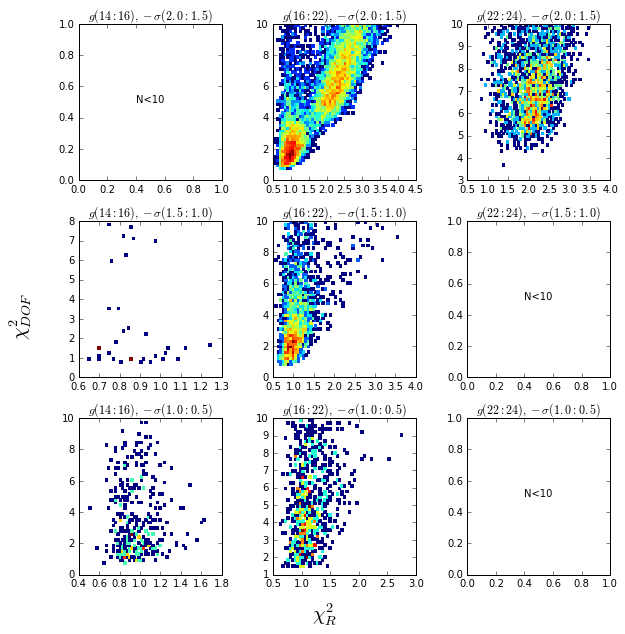

In [22]:
# select N in 60-160 range 
from matplotlib import rcParams
rcParams['text.usetex']=False
%matplotlib inline 
log10SigLims = [-2,-1.5,-1,-.5]
gMagLims = [14,16,22,24]

m1 = (  60 < varMetricsFull['N'].values ) & ( varMetricsFull['N'].values < 160)
mR = varMetricsFull['chi2R'].values < lim
mDOF=varMetricsFull['chi2DOF'].values < lim
mChi2= mR & mDOF  # logical and 
mComm = mChi2&m1  # common to all panels 

nObj = len(varMetricsFull['chi2R'].values[m])

# in each Sigma - Mag bin, plot chi2R vs  chi2DOF 
x = len(log10SigLims)-1
y = len(gMagLims)-1

fig,ax = plt.subplots(x, y, figsize=(3*x,3*y))
for i in range(x):
    for j in range(y):
        mSig = (np.log10(varMetricsFull['sigmaFull'].values) < log10SigLims[i+1] ) & \
               (np.log10(varMetricsFull['sigmaFull'].values) > log10SigLims[i])
        mMag = (varMetricsFull['psfMean'].values < gMagLims[j+1]) & \
               (varMetricsFull['psfMean'].values > gMagLims[j])
        mPanel = mSig & mMag
        m = mComm & mPanel
        ax[i,j].set_title(r'$g(%d:%d), -\sigma(%.1f:%.1f)$'%(gMagLims[j],gMagLims[j+1],-log10SigLims[i],-log10SigLims[i+1]))
        if np.sum(m) >  10 : 
            H, xedges, yedges = np.histogram2d(varMetricsFull['chi2R'].values[m],varMetricsFull['chi2DOF'].values[m], bins=50)
            H = np.rot90(H)
            H = np.flipud(H)
            # Mask zeros
            Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zeropltssssss
            # Plot 2D histogram using pcolor
            ax[i,j].pcolormesh(xedges,yedges,np.log10(Hmasked), cmap='jet')
        else : 
            ax[i,j].text(0.4,0.5, 'N<10')

#fig.text(0.25,0.9, str(gMagLims[0])+'<g<'+str(gMagLims[1]))                 
fig.text(0.5, 0.04, r'$\chi^{2}_{R}$', ha='center', va='center',fontsize=20)
fig.text(0.03, 0.5, r'$\chi^{2}_{DOF}$', ha='center', va='center', rotation='vertical',fontsize=20)

#fig.tight_layout()
fig.subplots_adjust(wspace=0.36, hspace=0.26, left=0.12, right=0.94, bottom=0.10, top=0.95)

plt.savefig('Varg00_21_1000_bootstraps_chi2DOF_chi2R_mag_sigma_bins.png')

## Plots like Sesar+2007 Fig.3 

Paper : http://www.astro.washington.edu/users/ivezic/Publications/Sesar07.pdf 

    Hard to do, because here I only have g magnitudes... Would have to have results from all 5 filters to make the color-color magnitudes...

## Bootstrap comparison (10000 vs 1000)....

In [21]:
# Compare sigma with 10000 bootstraps compared to 1000 bootstraps  
DirIn  = '/astro/store/scratch/tmp/suberlak/s13_stripe82/forced_phot_lt_23/NCSA/Var/'
name ='Varg00_21_10000_bootstraps.csv'
varMetrics1e4 = pd.read_csv(DirIn+name)
name ='Varg00_21_1000_bootstraps.csv'
varMetrics1e3 = pd.read_csv(DirIn+name)



OSError: File b'/astro/store/scratch/tmp/suberlak/s13_stripe82/forced_phot_lt_23/NCSA/Var/Varg00_21_10000_bootstraps.csv' does not exist

In [22]:
varMetricsJoin =  pd.merge(varMetrics1e3, varMetrics1e4, how='left', on='objectId',left_index=False, right_index=False, sort=True,
      suffixes=('_x', '_y'), copy=True)


In [23]:
varMetricsJoin[['sigmaFull_x','sigmaFull_y' ]].head()

,sigmaFull_x,sigmaFull_y
0,0.003416,0.003590
1,0.003350,0.003318
2,0.000000,0.000000
3,0.003079,0.003449
4,0.004473,0.004695


In [24]:
xMin = 55
m = varMetricsJoin['N_x'].values  > xMin
m1=varMetricsJoin[m]['sigmaFull_x'].values>0
#m2=varMetricsJoin[m]['sigmaFull_y'].values>0
m3=varMetricsJoin[m]['sigmaFull_x'].values<1
#m4=varMetricsJoin[m]['sigmaFull_y'].values<1 
msk =m1*m3


varMetricsPlot = varMetricsJoin[m][msk]

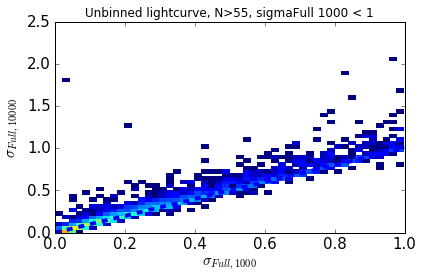

In [25]:
%matplotlib inline
# Plot some results : full LC : 
fig, ax = plt.subplots()

H, xedges, yedges = np.histogram2d(varMetricsPlot['sigmaFull_x'].values,varMetricsPlot['sigmaFull_y'].values, bins=50)
H = np.rot90(H)
H = np.flipud(H)
# Mask zeros
Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zeropltssssss
# Plot 2D histogram using pcolor
ax.pcolormesh(xedges,yedges,np.log10(Hmasked), cmap='jet')
ax.plot(np.linspace(0,1.5), np.linspace(0,1.5), ls='--', lw=4)
ax.set_xlabel(r'$\sigma_{Full, 1000}$', fontsize=15)
ax.set_ylabel(r'$\sigma_{Full, 10000}$', fontsize=15)
ax.set_title('Unbinned lightcurve, N>%d, sigmaFull 1000 < 1'%xMin)
ax.set_xlim(0,1)
#ax.set_ylim(0,lim)
ax.tick_params(axis='both', which='major', labelsize=15) 
plt.tight_layout()
plt.savefig('Varg00_21_bootstraps_compare_sigma.png')

In [26]:
x = np.abs(varMetricsPlot['sigmaFull_x'].values - varMetricsPlot['sigmaFull_y'].values) / varMetricsPlot['sigmaFull_x'].values

(array([  1.22608000e+05,   2.22600000e+04,   1.27300000e+04,
          8.86000000e+03,   6.72800000e+03,   5.19100000e+03,
          4.10300000e+03,   3.22200000e+03,   2.71000000e+03,
          2.28300000e+03,   1.87000000e+03,   1.53600000e+03,
          1.35600000e+03,   1.17200000e+03,   1.03300000e+03,
          9.02000000e+02,   8.34000000e+02,   7.26000000e+02,
          6.49000000e+02,   5.72000000e+02,   5.06000000e+02,
          4.68000000e+02,   4.03000000e+02,   3.86000000e+02,
          3.52000000e+02,   5.05000000e+02,   3.30000000e+02,
          2.94000000e+02,   2.35000000e+02,   2.37000000e+02,
          2.24000000e+02,   2.39000000e+02,   2.08000000e+02,
          2.08000000e+02,   1.56000000e+02,   1.37000000e+02,
          1.53000000e+02,   1.27000000e+02,   1.56000000e+02,
          1.33000000e+02,   1.28000000e+02,   1.12000000e+02,
          1.16000000e+02,   1.17000000e+02,   9.00000000e+01,
          9.00000000e+01,   9.10000000e+01,   7.10000000e+01,
        

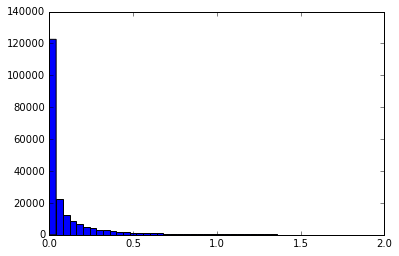

In [29]:
%matplotlib inline 
fig,ax = plt.subplots()
ax.hist(x[x<2], bins=50)

In [30]:
y = np.log10(varMetricsPlot['sigmaFull_x'].values / varMetricsPlot['sigmaFull_y'].values)

## varMetricsSeasonal : metrics for Seasons for full LC on g00_21.csv 

In [31]:
#  only for variable objects 
#     ( here : N=1000 bootstraps,  used strict variability definition 
#     m1*(m4 | m5), where  m1 = (varMetricsFull['sigmaFull'] > 0)
#      m4 = varMetricsFull['chi2DOF'] > (1 + 3.0 * np.sqrt(2 / N )) ##  170517
# m5 = varMetricsFull['chi2R'] > (1 + 3.0 * np.sqrt(2 / N))   )

In [32]:
DirIn  = '/astro/store/scratch/tmp/suberlak/s13_stripe82/forced_phot_lt_23/NCSA/Var/'
name = 'SeasVarg00_21_1000_bootstraps.csv'
varMetricsSeasonal= pd.read_csv(DirIn+name)

In [33]:
varMetricsSeasonal.head()

,objectId,season,N,avgMJD,chi2DOF,chi2R,flagLtTenPts,muFull,psfFluxMean,psfFluxMeanErr,psfFluxMedian,psfFluxMedianErr,psfFluxSigG,psfFluxSkew,psfFluxStDev,rangeMJD,sigmaFull
0,216172782516437336,0.0,13.0,52767.700160,2.201456,1.888938,NaN,0.015001399093876018,1.430169e-29,1.013931e-30,1.481434e-29,1.270774e-30,7.801653e-30,0.0,5.168289e-30,1532.757866,0.003422
1,216172782516437336,1.0,21.0,53667.596293,1.657391,0.974494,NaN,0.01577785650303653,1.567939e-29,1.231513e-30,1.687467e-29,1.543473e-30,8.669612e-30,0.0,5.946312e-30,82.891143,0.001552
2,216172782516437336,2.0,23.0,54028.141095,2.629647,1.276034,NaN,0.015562815870718573,1.528438e-29,1.115401e-30,1.884968e-29,1.397948e-30,9.055049e-30,0.0,5.610564e-30,92.921374,0.002257
3,216172782516437336,3.0,15.0,54395.611967,2.414379,1.270620,NaN,0.014557636730170884,1.349460e-29,1.214454e-30,1.704120e-29,1.522092e-30,6.241453e-30,0.0,6.736747e-30,64.959241,0.004777
4,216172782516437339,0.0,14.0,52777.885227,1.263577,0.836415,NaN,0.044455034371950274,4.434739e-29,1.070287e-30,4.384218e-29,1.341406e-30,3.851477e-30,0.0,4.493279e-30,1532.757866,0.001935


In [34]:
m = varMetricsSeasonal['chi2DOF'] < 10


(array([  7.22600000e+03,   1.69038000e+05,   2.40199000e+05,
          8.65880000e+04,   2.55660000e+04,   9.75600000e+03,
          3.68500000e+03,   1.15200000e+03,   2.14000000e+02,
          2.20000000e+01]),
 array([ 0.01523308,  0.48526884,  0.9553046 ,  1.42534036,  1.89537612,
         2.36541188,  2.83544764,  3.3054834 ,  3.77551916,  4.24555493,
         4.71559069]),
 <a list of 10 Patch objects>)

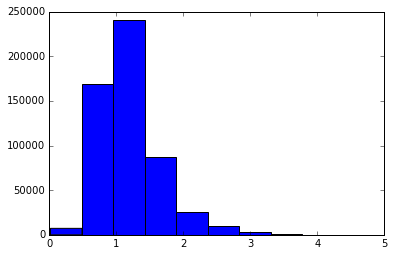

In [35]:
plt.hist(varMetricsSeasonal[m]['chi2R'].values)

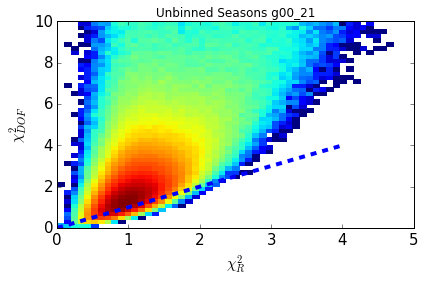

In [36]:
%matplotlib inline
# Plot some results : full LC : 
fig, ax = plt.subplots()

lim = 10
m1=varMetricsSeasonal['chi2R'].values<lim
m2=varMetricsSeasonal['chi2DOF'].values<lim
m= m1*m2  # logical and 

H, xedges, yedges = np.histogram2d(varMetricsSeasonal['chi2R'].values[m],varMetricsSeasonal['chi2DOF'].values[m], bins=50)
H = np.rot90(H)
H = np.flipud(H)
# Mask zeros
Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zeropltssssss
# Plot 2D histogram using pcolor
ax.pcolormesh(xedges,yedges,np.log10(Hmasked), cmap='jet')
ax.plot(np.linspace(0,4), np.linspace(0,4), ls='--', lw=4)
ax.set_xlabel(r'$\chi^{2}_{R}$', fontsize=15)
ax.set_ylabel(r'$\chi^{2}_{DOF}$', fontsize=15)
ax.set_title('Unbinned Seasons g00_21')
#ax.set_xlim(0,lim)
#ax.set_ylim(0,lim)
ax.tick_params(axis='both', which='major', labelsize=15) 
plt.tight_layout()
plt.savefig('SeasVarg00_21_1000_bootstraps_Chi2R_vs_Chi2DOF_yMax_10_VarOnly.png')

## varMetricsFullSeasonal : metrics for seasonally binned lightcurves 

In [37]:
DirIn  = '/astro/store/scratch/tmp/suberlak/s13_stripe82/forced_phot_lt_23/NCSA/Var/'
name = 'FullSeasVarg00_21_1000_bootstraps.csv'
varMetricsFullSeasonal= pd.read_csv(DirIn+name)

In [38]:
varMetricsFullSeasonal.head()

,objectId,Nseasons,chi2DOFmean,chi2DOFmedian,chi2Rmean,chi2Rmedian,muFull,psfFluxMeanErrMean,psfFluxMeanMean,sigmaFull
0,216172782516437336,4.0,0.681644,1.548436,0.845969,0.623895,0.014666,1.143825e-30,1.469002e-29,0.000000
1,216172782516437339,4.0,1.031613,0.230616,0.784815,0.324736,0.043201,1.213863e-30,4.300576e-29,0.000000
2,216172782516437346,4.0,0.874691,2.897802,0.627589,1.867501,0.011479,1.110731e-30,1.160085e-29,0.000000
3,216172782516437358,4.0,3.360890,5.273573,1.328345,1.499660,0.014187,1.121437e-30,1.432032e-29,0.001347
4,216172782516437360,4.0,1.442797,4.016759,1.010807,1.686722,0.009765,1.108440e-30,9.915796e-30,0.000303


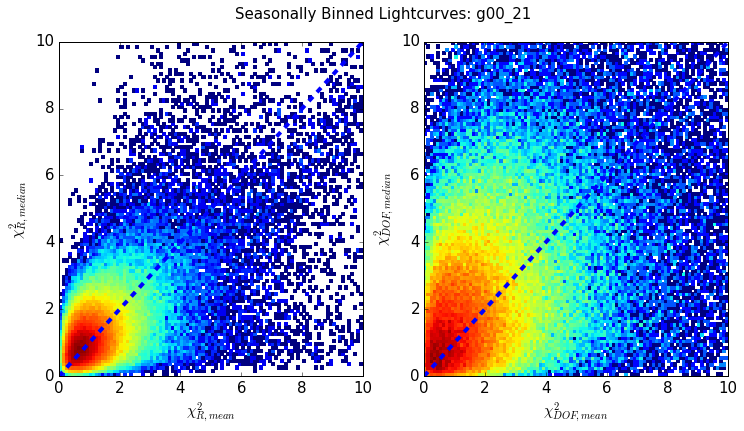

In [39]:
%matplotlib inline 

df = varMetricsFullSeasonal

from astroML.plotting import scatter_contour
#astroML.plotting.scatter_contour(x, y, levels=10, threshold=100, log_counts=False, histogram2d_args={}, plot_args={}, contour_args={}, ax=None)
fig, ax = plt.subplots(1,2,figsize=(12,6))
lim = 10

m1=df['chi2Rmean'].values<lim
m2=df['chi2Rmedian'].values<lim
m=m1*m2
#scatter_contour(seasonAvgChi2['chi2'].values[m], seasonAvgChi2['chi2R'].values[m] , threshold=200, 
#                log_counts=False, ax=ax)
#maskCol = (ri < xlim[1])&(ri>xlim[0])&(gr<ylim[1])&(gr>ylim[0])
nbins=100
H, xedges, yedges = np.histogram2d(df['chi2Rmean'].values[m],df['chi2Rmedian'].values[m],bins=nbins)
#H, xedges, yedges = np.histogram2d(grri_dropna[1],grri_dropna[0],bins=nbins)
# H needs to be rotated and flipped
H = np.rot90(H)
H = np.flipud(H)
# Mask zeros
Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zeropltssssss
# Plot 2D histogram using pcolor
ax[0].pcolormesh(xedges,yedges,np.log10(Hmasked), cmap='jet')
ax[0].plot(np.linspace(0,lim), np.linspace(0,lim), ls='--', lw=4)
ax[0].set_xlabel(r'$\chi^{2}_{R,mean}$', fontsize=15)
ax[0].set_ylabel(r'$\chi^{2}_{R, median}$', fontsize=15)
ax[0].set_xlim(0,lim)
ax[0].set_ylim(0,lim)
ax[0].tick_params(axis='both', which='major', labelsize=15)  

lim = 10
m1=df['chi2DOFmean'].values<lim
m2=df['chi2DOFmedian'].values<lim
m=m1*m2
#scatter_contour(seasonAvgChi2['chi2'].values[m], seasonAvgChi2['chi2R'].values[m] , threshold=200, 
#                log_counts=False, ax=ax)
#maskCol = (ri < xlim[1])&(ri>xlim[0])&(gr<ylim[1])&(gr>ylim[0])
nbins=100
H, xedges, yedges = np.histogram2d(df['chi2DOFmean'].values[m],df['chi2DOFmedian'].values[m],bins=nbins)
#H, xedges, yedges = np.histogram2d(grri_dropna[1],grri_dropna[0],bins=nbins)
# H needs to be rotated and flipped
H = np.rot90(H)
H = np.flipud(H)
# Mask zeros
Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zeropltssssss
# Plot 2D histogram using pcolor
ax[1].pcolormesh(xedges,yedges,np.log10(Hmasked), cmap='jet')
ax[1].plot(np.linspace(0,lim), np.linspace(0,lim), ls='--', lw=4)
ax[1].set_xlabel(r'$\chi^{2}_{DOF,mean}$', fontsize=15)
ax[1].set_ylabel(r'$\chi^{2}_{DOF, median}$', fontsize=15)
ax[1].set_xlim(0,lim)
ax[1].set_ylim(0,lim)
ax[1].tick_params(axis='both', which='major', labelsize=15) 
fig.subplots_adjust( top=0.90)
fig.suptitle('Seasonally Binned Lightcurves: g00_21', fontsize=15)

#plt.tight_layout()
plt.savefig('FullSeasVarg00_21_1000_bootstraps_Chi2R_vs_Chi2DOF.png')

In [43]:
np.shape(H)

(100, 100)

In [44]:
np.shape(xedges)

(101,)